## Bacterial culture DESI-MS library

Analysis of the bacterial library DESI-MS dataset.

In [1]:
import pandas as pds
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu

In [2]:
bactLibNeg = pds.read_excel('../../Data/Bacteria library DESI Negative.xlsx')
bactLibPos = pds.read_excel('../../Data/Bacteria library DESI Positive.xlsx')
bactLibNeg = bactLibNeg.loc[bactLibNeg['Type'] != 'Background']
bactLibPos = bactLibPos.loc[~bactLibPos['Type'].isin(['Background', np.nan])]

# Type cast the Isolate IDs to int
bactLibNeg['Isolate'] = bactLibNeg['Isolate'].astype(int)
bactLibPos['Isolate'] = bactLibPos['Isolate'].astype(int)

In [3]:
identifiedFeatures = pds.read_excel('../../Data/Extendend Data Table 2 LDOM vs LDEPL.xlsx')
negativeFeatures = identifiedFeatures.loc[identifiedFeatures['DESI-MS mode'] == 'negative']
positiveFeatures = identifiedFeatures.loc[identifiedFeatures['DESI-MS mode'] == 'positive']

In [4]:
speciesSorted = ['L. crispatus', 'L. iners', 'L. gasseri', 'L. jensenii', 'B. breve', 'A. vaginae', 
                 'G. vaginalis', 'P. amnii', 'P. disiens', 'P. timonensis', 'S. agalactiae', 
                 'S. anginosus', 'S. aureus ']

In [5]:
ppm_error = lambda x,y: abs(((x-y)/y)*1e6)

Iterate through all species/isolates and compare the levels of peaks found significant in the VMET and VMET2 linear mixed model analysis in bacterial biomass with their corresponding culture media sample.

Peaks are matched with a tolerance of 5 ppm. For each matching peak, the replicates from the isolate are compared with the replicates from the culture media with the Wilcoxon-Mann-Whitney non-parametric test. If significant, the log fold change between the mean intensity in the bacterial samples over the mean intensity from the culture media is stored as the main effect size estimate.

In [6]:
resultsDict = dict()

for currentSpecies in speciesSorted:

    currentSpeciesDframe = bactLibNeg.loc[bactLibNeg['Species'] == currentSpecies]
    currentSpeciesDframePos = bactLibPos.loc[bactLibPos['Species'] == currentSpecies]

    isolatesList = currentSpeciesDframe['Isolate'].unique()

    currentSpeciesDict = dict()
    
    for isolate in isolatesList:
        currentIsolateDframe = currentSpeciesDframe.loc[currentSpeciesDframe['Isolate'] == isolate]
        currentIsolateDframePos = currentSpeciesDframePos.loc[currentSpeciesDframePos['Isolate'] == isolate]

        agarSamples = currentIsolateDframe['Type'] == 'Agar'
        bacterialSamples = currentIsolateDframe['Type'] == 'Bacteria'
        agarSamplesPos = currentIsolateDframePos['Type'] == 'Agar'
        bacterialSamplesPos = currentIsolateDframePos['Type'] == 'Bacteria'

        currentIsolateResults = list()
        for featureIdx, featureRow in negativeFeatures.iterrows():
            featureMz = featureRow['VMET2_m/z measured']
            matchingFeatureIdx = np.argmin(ppm_error(bactLibNeg.columns[8::],  featureMz))
            matchingFeature = bactLibNeg.columns[matchingFeatureIdx + 8]
            matchingErrorFeature = np.argmin(ppm_error(bactLibNeg.columns[matchingFeatureIdx + 8],  featureMz))
            
            if ppm_error(featureMz, bactLibNeg.columns[matchingFeatureIdx + 8]) <= 5:
                # If there is no matching agar for this isolate, use all samples from this bacterial species.
                if currentIsolateDframe.loc[agarSamples, matchingFeature].shape[0] == 0:
                    currentIsolateDframe = pds.concat([currentIsolateDframe, currentSpeciesDframe.loc[currentSpeciesDframe['Type'] == 'Agar']], axis=0)
                    agarSamples = currentIsolateDframe['Type'] == 'Agar'
                    bacterialSamples = currentIsolateDframe['Type'] == 'Bacteria'
                try:
                    mwhTestResults = mannwhitneyu(currentIsolateDframe.loc[agarSamples, matchingFeature], currentIsolateDframe.loc[bacterialSamples, matchingFeature])
                    meanFoldChange = currentIsolateDframe.loc[bacterialSamples, matchingFeature].mean()/currentIsolateDframe.loc[agarSamples, matchingFeature].mean()
                    currentIsolateResults.append(('+', featureMz, (meanFoldChange, mwhTestResults.pvalue)))
                except:
                    currentIsolateResults.append(('-', featureMz, (np.nan, np.nan)))
            else:
                currentIsolateResults.append(('-', featureMz, (np.nan, np.nan)))
                
        for featureIdx, featureRow in positiveFeatures.iterrows():
            
            featureMz = featureRow['VMET2_m/z measured']
            matchingFeatureIdx = np.argmin(ppm_error(bactLibPos.columns[8::],  featureMz))
            matchingFeature = bactLibPos.columns[matchingFeatureIdx + 8]
            matchingErrorFeature = np.argmin(ppm_error(bactLibPos.columns[matchingFeatureIdx + 8],  featureMz))
            
            if ppm_error(featureMz, bactLibPos.columns[matchingFeatureIdx + 8]) <= 5:
                # If there is no matching agar for this isolate, use all samples from this bacterial species.
                if currentIsolateDframePos.loc[agarSamplesPos, matchingFeature].shape[0] == 0:
                    currentIsolateDframePos = pds.concat([currentIsolateDframePos, currentSpeciesDframePos.loc[currentSpeciesDframePos['Type'] == 'Agar']], axis=0)
                    agarSamplesPos = currentIsolateDframePos['Type'] == 'Agar'
                    bacterialSamplesPos = currentIsolateDframePos['Type'] == 'Bacteria'
                try:
                    mwhTestResults = mannwhitneyu(currentIsolateDframePos.loc[agarSamplesPos, matchingFeature], currentIsolateDframePos.loc[bacterialSamplesPos, matchingFeature])
                    meanFoldChange = currentIsolateDframePos.loc[bacterialSamplesPos, matchingFeature].mean()/currentIsolateDframePos.loc[agarSamplesPos, matchingFeature].mean()
                    currentIsolateResults.append(('+', featureMz, (meanFoldChange, mwhTestResults.pvalue)))
                except:
                    currentIsolateResults.append(('+', featureMz, (np.nan, np.nan)))
            else:
                currentIsolateResults.append(('+', featureMz, (np.nan, np.nan)))
                
        currentSpeciesDict[isolate] = currentIsolateResults
        
    resultsDict[currentSpecies] = currentSpeciesDict

/home/gd2212/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:7171: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [7]:
# Number of identified features Negative + Positive mode
x_dim = 113
# Number of isolates
y_dim = len(bactLibNeg['Isolate'].unique())
heatmapMatrix = np.zeros((x_dim, y_dim))

column_idx = 0
speciesNames = list()
isolateNames = list()

for species in resultsDict.keys():
    currentSpecies = resultsDict[species]
    for isolate in currentSpecies.keys():
        speciesNames.append(species)
        isolateNames.append(isolate)
        currentIsolate = currentSpecies[isolate]
        for rowIdx in range(113):
            currentValue = currentIsolate[rowIdx][2]
            if ~np.isnan(currentValue[0]):
                if currentValue[1] < 0.05:
                    heatmapMatrix[rowIdx, column_idx] = currentValue[0]
        column_idx += 1
        

In [8]:
featureNames = negativeFeatures['Metabolite Annotation'].values + ' (-)'
featureNames = np.r_[featureNames, positiveFeatures['Metabolite Annotation'].values + ' (+)']
associationDirection = negativeFeatures['Elevated in'].values
associationDirection = np.r_[associationDirection, positiveFeatures['Elevated in'].values]


In [9]:
zeroOnlyRows = np.where(heatmapMatrix.sum(1) == 0)[0]
featureNames = np.delete(featureNames, zeroOnlyRows)
associationDirection = np.delete(associationDirection, zeroOnlyRows)

#featureNames = np.delete(featureNames, -1)

heatmapMatrix = np.delete(heatmapMatrix, zeroOnlyRows, axis=0)
#heatmapMatrix = np.delete(heatmapMatrix, -1, axis=1)

In [10]:
# Sort the heatmap rows according to their association sign in the VMET/VMET2 datasets
featureNames_sorted = np.array(['Oxoproline (-)', 'Leucine (-)', 'Leucine (+)', 
       'Aspartic acid (-)', 'Glutamate (-)', 'Valyl-Alanine (-)', 'Leucyl-Serine (-)', 
       'Leucyl-Threonine (-)', 'Valyl-Glutamine (-)', 'Glutamyl-Leucine (-)', 
       'Lyso-PG(16:0) (-)',  'Vinylaniline (+)', 'Lysine (+)',
       'Phenylalanine (-)', 'Phenylalanine (+)', 'Arginine (+)', 'Unknown (+)',
       'Maltotriose (+)', 'Oxypurinol (-)', 'Linolenic Acid (C18:3) (-)',
       'Linoleic acid (C18:2) (-)', 'Oleic Acid (C18:1) (-)', 'Isotope Oleic acid (18:1) (-)',
       'Stearic acid (18:0) (-)', 'Isotope Stearic acid (C18:0) (-)',
       'Eicosanoic acid, Arachidic Acid (C20:0) (-)',
       'Lignoceric acid (C24:0) (-)'])

sortingOrder = [np.where(featureNames == x)[0][0] for x in featureNames_sorted]

heatmapMatrix = heatmapMatrix[sortingOrder, :]

### Generate the Figure 3 - Bacterial Library heatmap

In [11]:
# %matplotlib notebook

In [12]:
toCSTMapping = {'L. crispatus':0, 'L. gasseri':2, 'L. iners':1, 'L. jensenii':4, 
                'A. vaginae':3, 'G. vaginalis':3, 'P. amnii':3, 'P. disiens':3, 
                'P. timonensis':3, 'S. agalactiae':3, 'S. anginosus':3, 'S. aureus ': 3, 'B. breve':5}

directionMapping = {'LDOM':0, 'LDEPL':1}
cmap_direction = ListedColormap(["#1a75ff", "#00b36b"])

In [13]:
cst_colors_classic = ["#1a75ff", "#00b36b", "#cca300", "#ff3333", "#ff80d5", "#9494b8", "#9900cc"]
cmap_classic = ListedColormap(cst_colors_classic)

/home/gd2212/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


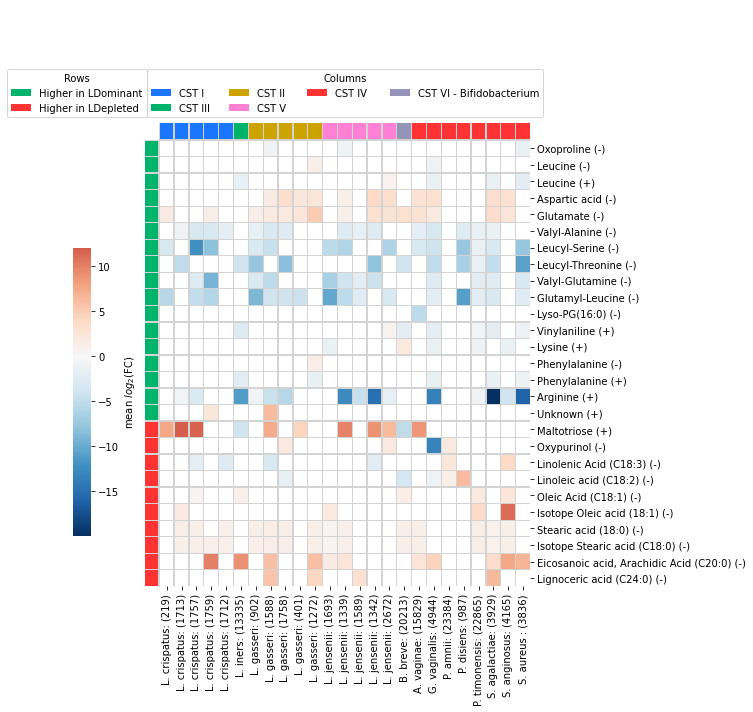

In [14]:
# sns.set_theme()
#fig, ax = plt.subplots(1)
#ax = sns.heatmap(np.log2(heatmapMatrix), ax=ax, cmap='RdYlBu_r', linewidths=.3, 
#                 linecolor='lightgray', center=0, mask=heatmapMatrix == 0, yticklabels=featureNames,
#                 xticklabels=speciesNames)

toCSTMapping = {'L. crispatus':0, 'L. gasseri':2, 'L. iners':1, 'L. jensenii':4, 
                'A. vaginae':3, 'G. vaginalis':3, 'P. amnii':3, 'P. disiens':3, 
                'P. timonensis':3, 'S. agalactiae':3, 'S. anginosus':3, 'S. aureus ': 3, 'B. breve':5}

directionMapping = {'LDOM':0, 'LDEPL':1}
cmap_direction = ListedColormap(["#00b36b", "#ff3333"])

cst_colors_classic = ["#1a75ff", "#00b36b", "#cca300", "#ff3333", "#ff80d5", "#9494b8", "#9900cc"]
cmap_classic = ListedColormap(cst_colors_classic)

col_colors = pds.Series([toCSTMapping[x] for x in speciesNames]).map(cmap_classic)
row_colors = pds.Series([directionMapping[x] for x in associationDirection]).map(cmap_direction)
row_colors = row_colors.loc[sortingOrder]
speciesIsolateID = [x + ': (' + str(isolateNames[idx]) + ')' for (idx, x) in enumerate(speciesNames)]

htplot = sns.clustermap(np.log2(heatmapMatrix), row_cluster=False, col_cluster=False, 
                        col_colors=list(col_colors), row_colors=list(row_colors),
               center=0, mask=heatmapMatrix == 0, cmap='RdBu_r',  linewidths=.3, linecolor='lightgray', 
                        xticklabels=speciesIsolateID, yticklabels=featureNames_sorted)

htplot.cax.set_position([0.05, 0.25, 0.025, 0.4])
htplot.cax.set_ylabel('mean $log_{2}$(FC)')

label_Map = {0:'CST I', 1:'CST III', 
             2:'CST II', 3:'CST IV ', 4:'CST V',
             5:'CST VI - Bifidobacterium'}


for label in [0, 1, 2, 4, 3, 5]:
    htplot.ax_col_dendrogram.bar(0, 0, color=cmap_classic(label), label=label_Map[label], linewidth=0)
    
for label in [(0, 'Higher in LDominant'), (1, 'Higher in LDepleted')]:
    htplot.ax_row_dendrogram.bar(0, 0, color=cmap_direction(label[0]), label=label[1], linewidth=0)
    
htplot.ax_col_dendrogram.legend(bbox_to_anchor=(0.5, 0.5), loc='upper center', ncol=4, title='Columns')
htplot.ax_row_dendrogram.legend(bbox_to_anchor=(0.3, 1.17), loc='upper center', ncol=1, title='Rows')

htplot.savefig('./Figure 3 - BacterialLibrary.png', dpi=130)

#htplot.savefig('BactLibrary.eps', dpi=130)
#htplot.savefig('BactLibrary.svg', dpi=130)